# Promoter footprints

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
from os.path import exists
import seaborn as sns
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import spearmanr

sns.set()

from sklearn.decomposition import FastICA

## MaveNN

In [2]:
#Load mavenn
import mavenn

2022-12-15 15:57:22.984480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 15:57:26.821230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 15:57:26.821302: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-15 15:57:27.255932: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-15 15:57:32.378461: W tensorflow/stream_executor/platform/default

In [3]:
promoter = "syn_rand"
gc = "LB"

sites = []

Import data and format table. We randomly assign sequences to training, test and validation data and compute the relative counts for each sequence.

In [4]:
# Get file path
filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)

# Import file
df = pd.read_csv(filepath)

# Filter
df = df.loc[df['gDNA_count'] > 100, :]
df.reset_index(drop=True, inplace=True)
# Rename columns to work with MaveNN
df_arr = df.rename(columns={"gDNA_count": "ct_0", "cDNA_count": "ct_1", "promoter": "seq"})

df_arr = pd.concat([df_arr, df_arr, df_arr, df_arr]).reset_index(drop=True)
df_arr
# Set ratio of training and test data
training_p = 0.8
test_p = 0.1

# Randomly choose promoters for test and validation set
df_arr['set'] = np.random.choice(["training", "validation", "test"], len(df_arr), p=[0.8, 0.19, 0.01])
df_arr['ct_r'] = (1 + df_arr['ct_1']) / (df_arr['ct_0'])
df_arr = df_arr[['set', 'ct_r', 'seq']]


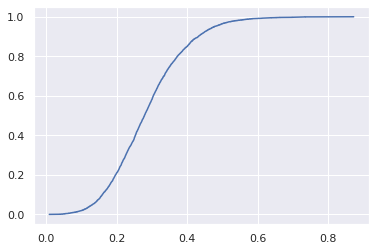

In [5]:
plt.plot(np.sort(df_arr['ct_r']), np.arange(0,len(df_arr['ct_r']))/len(df_arr['ct_r']))

In [298]:
quant_arr

[-0.6716959194693568, -0.5543276052610246, -0.454545964964432]

In [6]:
bins = 4

# Array for different bins
bin_arr = [np.zeros(len(df_arr['ct_r'])) for i in range(bins)]

# Percentages of sequences in bins
quant_arr = [np.percentile(np.log10(np.sort(df_arr['ct_r'])), 100 / bins * (i+1)) for i in range(bins-1)]

# Assign to bins
for i in range(len(df_arr['ct_r'])):
    found = False
    j = 0
    while found==False:
        if np.log10(df_arr['ct_r'][i]) < quant_arr[j]:
            bin_arr[j][i] = 1
            found = True
        j += 1
        if j == (bins-1):
            bin_arr[-1][i] = 1
            found = True
        if j >= bins:
            print("Safety stop for while loop")
            break
            
bin_cols = [f'ct_{i}' for i in range(bins)]
for i in range(bins):
    df_arr[f'ct_{i}'] = bin_arr[i]

In [7]:
df_arr

,set,ct_r,seq,ct_0,ct_1,ct_2,ct_3
0,training,0.232181,CCAGGTTTCCCGACTGGGAGGCGGCCAGTGAGCGCAACGCAATTAA...,0.0,1.0,0.0,0.0
1,training,0.267937,ACAGGTTTCCCGACTTGAAAGCGGGCAGAGAGCGCAACGCAATCAA...,0.0,1.0,0.0,0.0
2,training,0.113924,ACAGGTTTCGCGACTAGAAAGCGGGCACTGAGCGCACCGCAATTAA...,1.0,0.0,0.0,0.0
3,training,0.435573,ACAGGTTTCTCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.0,0.0,0.0,1.0
4,training,0.262332,ACAGCGTTGCCGACTGGAAAGCGGGCTCTGAGCGCAACGCAATTTA...,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
14931,training,0.266376,ACAGGTTACCCGACTGGCAAACGGGCAGTAAGCGCAACGCAATTAA...,0.0,1.0,0.0,0.0
14932,validation,0.517929,ACAGGTTTCCCAACTGGAAAGGGTGCAGGGAGCGCAACGCAATTTA...,0.0,0.0,0.0,1.0
14933,training,0.321190,ACAGGTTTGCCGACTGGGAAGCGGGCATTGAGCGCAACGGAATTTA...,0.0,0.0,1.0,1.0
14934,training,0.200856,ACATGAATCCCGACTGGAGAGCGAGCAGTGAGCGCAACGCAATTAA...,1.0,0.0,0.0,0.0


In [8]:
model = mavenn.Model(
    L=160,
    Y=bins,
    alphabet='dna',
    regression_type='MPA',
    gpmap_type='additive',
    mpa_hidden_nodes=100
)

trainval_df, test_df = mavenn.split_dataset(df_arr)   

# Set training data
model.set_data(x=trainval_df['seq'],
               y=trainval_df[bin_cols],
               validation_flags=trainval_df['validation'],
               shuffle=True)

# Fit model to data
model.fit(learning_rate=1e-4,
          epochs=2000,
          batch_size=100,
          early_stopping=False,
          #early_stopping_patience=25,
          linear_initialization=False,
          verbose=False);

2022-12-15 15:58:08.877357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-15 15:58:08.883403: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 15:58:08.883489: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (delbruck): /proc/driver/nvidia/version does not exist
2022-12-15 15:58:08.891391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training set   :   12,017 observations (  80.46%)
Validation set :    2,775 observations (  18.58%)
Test set       :      144 observations (   0.96%)
-------------------------------------------------
Total dataset  :   14,936 observations ( 100.00%)

N = 14,792 observations set as training data.
Using 18.8% for validation.
Data shuffled.
Time to set data: 0.619 sec.


0epoch [00:00, ?epoch/s]

KeyboardInterrupt: 

In [ ]:
# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['seq'], y=test_df[bin_cols])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

param_dict = model.layer_gpmap.get_params()

In [ ]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=[5, 5])

# Plot I_var_train, the variational information on training data as a function of epoch
ax.plot(model.history['I_var'], label=r'I_var_train')

# Plot I_var_val, the variational information on validation data as a function of epoch
ax.plot(model.history['val_I_var'], label=r'val_I_var')

# Show I_pred_test, the predictive information of the final model on test data
ax.axhline(I_pred, color='C3', linestyle=':', label=r'test_I_pred')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('Training history: variational information')
ax.legend()

plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,3))

#ax[0].set_title("Differences at each position in frequencies.")
ax.set_yticks([0, 1, 2, 3], ["A", "C", "G", "T"])

z1_plot = ax.imshow(
    param_dict['theta_lc'].T, 
    aspect="auto", 
    cmap="bwr", 
    vmin=-np.max(np.abs(param_dict['theta_lc'])), 
    vmax=np.max(np.abs(param_dict['theta_lc']))
)

ax.grid(False)



In [ ]:
prob_mat = np.exp(param_dict['theta_lc']).T / np.sum(np.exp(param_dict['theta_lc']).T, axis=0)
rel_ent = [np.sum([prob_mat[i, j] * np.log2(prob_mat[i, j] / 0.25) for i in range(4)]) for j in range(160)]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.set_ylabel("relative entropy")
ax.set_xlabel("position relative to TSS")
d=1

ax.bar(range(-115+d, 45-d), [np.mean(rel_ent[i-d:i+d]) for i in range(-115+d, 45-d)])
#ax.bar(range(-115+d, 45-d), [np.mean(rel_ent[i-d:i+d]) for i in range(-115+d, 45-d)])

In [240]:
color_dict={
    "act":"#BFD598",
    "dual":"#F3DAA9",
    "rep":"#E8B19D",
    "pol":"#A9BFE3"
   }

## Expression shift

In [241]:
def expression_shift(promoter, gc, sites, d=1):
    """
    Plot promoter footprint and add annotations for annotated sites.
    """
        
    # Double check that the files for the promoter exist
    filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
    if not exists(filepath):
        return
    df = pd.read_csv(filepath)

    # Filter
    df = df.loc[df.gDNA_count > 10, :]
    df["relative_counts"] = df.cDNA_count / df.gDNA_count
    df["total_counts"] = df.cDNA_count + df.gDNA_count

    # transform sequences to integers
    DNA_dict = {"A":0, "C":1, "G":2, "T":3}
    def make_int(x):
        return np.array([DNA_dict[y] for y in x])

    df['int_promoter'] = df['promoter'].apply(make_int)

    # compute nucleotide frequencies
    freq_mat = np.zeros([2, 4, 160])
    for gDNA_counts, cDNA_counts, prom in zip(df['gDNA_count'], df['cDNA_count'], df['int_promoter']):
        freq_mat[0, prom, np.arange(160)] += gDNA_counts
        freq_mat[1, prom, np.arange(160)] += cDNA_counts

    freq_mat /= np.sum(df.total_counts)

    # find wild type sequence 
    wt_seq = np.argmax(np.sum(freq_mat, axis=0), axis=0)

    def is_mut(x):
        return ~np.equal(x, wt_seq)

    df['is_mutated'] = df['int_promoter'].apply(is_mut)

    mean_rel_counts = np.mean(df["relative_counts"])
    tot_counts = np.sum(df["total_counts"])

    ex_shift_arr = np.zeros(160)
    for x, seq, c in zip(df['relative_counts'], df['is_mutated'], df['total_counts']):
        ex_shift_arr[seq] += (x - mean_rel_counts) #* -1/np.log(c / tot_counts)

    # make plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=True)

    # colors for plotting (from PBoC)
    color_dict={
        "act":"#BFD598",
        "dual":"#F3DAA9",
        "rep":"#E8B19D",
        "pol":"#A9BFE3"
       }

    # compute rolling average for expression shift
    ex_shift_av = [np.sum(ex_shift_arr[i-d:i+d]) / (2 * d + 1) for i in range(d, 160-d)]
    ex_shift_colors = [color_dict["rep"] if x > 0 else color_dict["act"] for x in ex_shift_av]

    # plot expression shift
    ax.bar(np.arange(160 - 2 * d) - (115-d), ex_shift_av, color=ex_shift_colors)
    ax.set_ylabel("Expression Shift")
    ax.set_title(promoter + " in " + gc)

    # plot patches
    for element in sites:
        if element[2] == "act":
            h = 1.15 * np.min(ex_shift_av)
        else:
            h = 1.15 * np.max(ex_shift_av)
        pp1 = Rectangle(
            (element[0], 0), 
            -(element[0] - element[1]), 
            h, 
            alpha=0.2, 
            edgecolor="black", 
            facecolor=color_dict[element[2]]
        )
        ax.add_patch(pp1)
        ax.annotate(element[3], (element[0], h)) 

    plt.subplots_adjust(wspace=0, hspace=0)
        
    for element in sites:
            if element[2] == "act":
                h = 1.15 * np.min(ex_shift_av)
            else:
                h = 1.15 * np.max(ex_shift_av)
            pp1 = Rectangle(
                (element[0], 0), 
                -(element[0] - element[1]), 
                h, 
                alpha=0.2, 
                edgecolor="black", 
                facecolor=color_dict[element[2]]
            )
            ax.add_patch(pp1)
            ax.annotate(element[3], (element[0], h)) 
    plt.tight_layout()     
    return

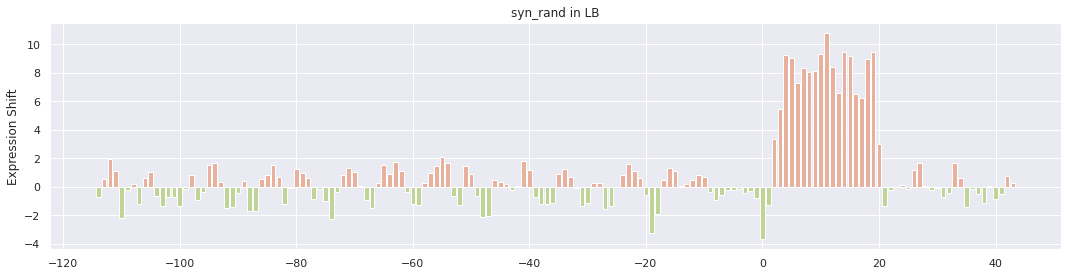

In [281]:
promoter = "syn_rand"

sites = []


expression_shift(promoter, "LB", sites, d=1)

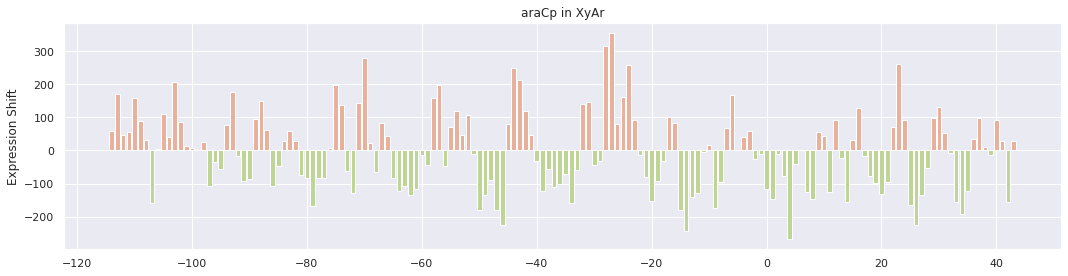

In [246]:
promoter = "araCp"

sites = [
    (-113, -97, "act", "AraC"),
    (-92, -76, "dual", "AraC"),
    (-65, -44, "act", "Crp"),
    (-39, -23, "rep", "AraC"),
    (-28, -11, "rep", "XylR"),
    (-18, -2, "rep", "AraC"),
    (-7, 11, "rep", "XylR"),
]

sites=[]

expression_shift(promoter, "XyAr",sites, d=1)

In [244]:
promoter = "araCp"

sites = [
    (-113, -97, "act", "AraC"),
    (-92, -76, "dual", "AraC"),
    (-65, -44, "act", "Crp"),
    (-39, -23, "rep", "AraC"),
    (-28, -11, "rep", "XylR"),
    (-18, -2, "rep", "AraC"),
    (-7, 11, "rep", "XylR"),
]
expression_shift(promoter, sites, d=8)

TypeError: expression_shift() missing 1 required positional argument: 'sites'

In [ ]:
promoter = "rspAp"

sites = [
    (-39, -31, "rep", "YdfH"),
    (-71, -50, "act", "Crp"),
]
expression_shift(promoter, sites, d=3)

In [ ]:
promoter = "araBp"

sites = [
    (-125, -109, "rep", "AraC"),
    (-104, -83, "act", "Crp"),
    (-72, -56, "dual", "AraC"),
    (-51, -35, "act", "AraC"),
]

expression_shift(promoter, sites, d=3)

### Synthetic data

In [ ]:
promoter = "syn"

sites = []

expression_shift(promoter, sites, d=1)

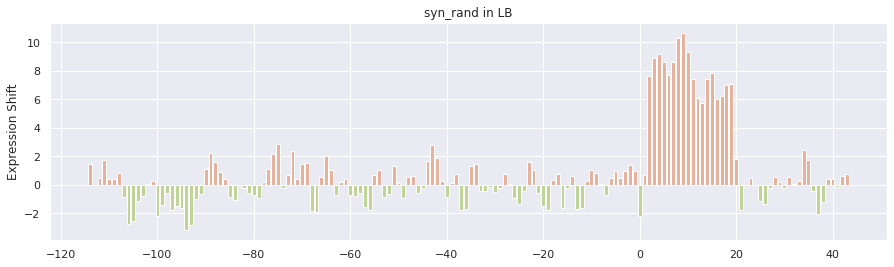

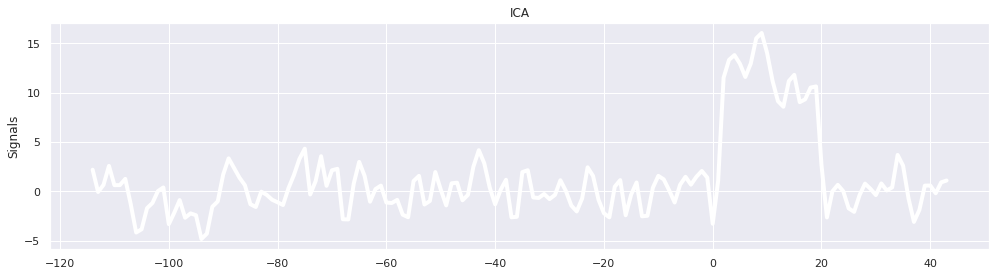

In [93]:
promoter = "syn_rand"

sites = []

expression_shift(promoter, sites, d=1)

# Frequency matrices

In [ ]:
def freq_mat(promoter, gc, sites, d=1):
    filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
    if not exists(filepath):
        return
    df = pd.read_csv(filepath)
    # Filter
    df = df.loc[df.gDNA_count > 10, :]
    df["relative_counts"] = df.cDNA_count / df.gDNA_count
    df["total_counts"] = df.cDNA_count + df.gDNA_count

    # transform sequences to integers
    DNA_dict = {"A":0, "C":1, "G":2, "T":3}
    def make_int(x):
        return np.array([DNA_dict[y] for y in x])

    df['int_promoter'] = df['promoter'].apply(make_int)
    # compute nucleotide frequencies
    freq_mat = np.zeros([2, 4, 160])
    tot_gDNA = np.sum(df['gDNA_count'])
    tot_cDNA = np.sum(df['cDNA_count'])
    for gDNA_counts, cDNA_counts, prom in zip(df['gDNA_count'], df['cDNA_count'], df['int_promoter']):
        freq_mat[0, prom, np.arange(160)] += gDNA_counts / tot_gDNA
        freq_mat[1, prom, np.arange(160)] += cDNA_counts / tot_cDNA
    
    # find wild type sequence 
    wt_seq = np.argmax(np.sum(freq_mat, axis=0), axis=0)
    
    freq_diffs = (freq_mat[0, :, :] - freq_mat[1, :, :])
    
    fig, ax = plt.subplots(3, 1, figsize=(15,8))
    
    ax[0].set_title("Differences at each position in frequencies.")
    ax[0].set_yticks([0, 1, 2, 3], ["A", "C", "G", "T"])
    ax[0].set_xticks([])
    ax[1].set_title("Differences at each position in frequencies.")
    ax[2].set_title("Differences in occurence of wild type letter between RNA and DNA.")
    ax[2].set_xlabel("Position")
    
    z1_plot = ax[0].imshow(
        freq_diffs, 
        aspect="auto", 
        cmap="bwr", 
        vmin=-np.max(np.abs(freq_diffs)), 
        vmax=np.max(np.abs(freq_diffs))
    )
    
    ax[0].grid(False)
    divider = make_axes_locatable(ax[0])

    ax_cb = divider.append_axes("right", size="2%", pad=0.05)
    fig_ = ax[0].get_figure()
    fig_.add_axes(ax_cb)

    plt.colorbar(z1_plot, cax=ax_cb)
    y = np.sum(np.abs(freq_diffs), axis=0)
    ax[1].bar(np.arange(d, 160-d) - 115, [np.sum(y[i-d:i+d+1]) / (2 * d + 1) for i in range(d, 160-d)])
    diff_av = [np.sum(freq_diffs[wt_seq, np.arange(160)][i-d:i+d+1]) / (2 * d + 1) for i in range(d, 160-d)]
    ax[2].bar(np.arange(d, 160-d) - 115, diff_av)
    
    for element in sites:
        if element[2] == "act":
            h = 1.15 * np.min(diff_av)
        else:
            h = 1.15 * np.max(diff_av)
        pp1 = Rectangle(
            (element[0], 0), 
            -(element[0] - element[1]), 
            h, 
            alpha=0.2, 
            edgecolor="black", 
            facecolor=color_dict[element[2]]
        )
        ax[2].add_patch(pp1)
        ax[2].annotate(element[3], (element[0], h)) 
    
    plt.tight_layout()
    return 

In [ ]:
promoter = "syn_rand"
sites=[]
freq_mat(promoter, "LB", sites, d=1)

In [ ]:
promoter = "araBp"

sites = [
    (-125, -109, "rep", "AraC"),
    (-104, -83, "act", "Crp"),
    (-72, -56, "dual", "AraC"),
    (-51, -35, "act", "AraC"),
]

freq_mat(promoter, "XyAr", sites, d=2)

In [ ]:
promoter = "rspAp"

sites = [
    (-39, -31, "rep", "YdfH"),
    (-71, -50, "act", "Crp"),
]

freq_mat(promoter, "Gluc", sites, d=2)

In [ ]:
promoter = "araCp"

sites = [
    (-113, -97, "act", "AraC"),
    (-92, -76, "dual", "AraC"),
    (-65, -44, "act", "Crp"),
    (-39, -23, "rep", "AraC"),
    (-28, -11, "rep", "XylR"),
    (-18, -2, "rep", "AraC"),
    (-7, 11, "rep", "XylR"),
]

freq_mat(promoter, "LB", sites, d=2)

In [ ]:
promoter = find_promoter("ecnB")

sites = [
    (9, 28, "rep", "OmpR"),
]
freq_mat(promoter, "Etoh", sites, d=1)

## ICA

In [ ]:
transformer = FastICA(
    n_components=7,
    random_state=0,
    whiten='unit-variance')
X_transformed = transformer.fit_transform(X)
X_transformed.shape

## Mutual information and Linear Regression

In [ ]:
def mut_information(p):
    """
    Compute mutial information from joint probability distribution p(m, mu).
    """
    l = np.size(p, 2)
    I = np.zeros(l)
    for i in range(l):
        p_mu = np.sum(p[:, :, i], axis=0)
        p_m = np.sum(p[:, :, i], axis=1)
        I[i] = np.sum([p[m, mu, i] * np.log2(p[m, mu, i] / p_m[m] / p_mu[mu]) for mu in [0, 1] for m in [0, 1]])

    return I

    

def make_footprints(promoter, sites, d_lin=2, d_MI=2):
    """
    Plot promoter footprint and add annotations for annotated sites.
    """
    
    # Iterate through growth conditions
    for gc in ["LB", "Etoh", "Gluc", "XyAr"]:
        
        # Double check that the files for the promoter exist
        filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
        if not exists(filepath):
            break
        df = pd.read_csv(filepath)
        # Filter
        df = df.loc[df.gDNA_count > 10, :]
        # read counts and compute total counts per sequence
        df["total_counts"] = [x + y for x, y in zip(df.cDNA_count, df.gDNA_count)]
    
        # transform sequences to integers
        DNA_dict = {"A":0, "C":1, "G":2, "T":3}
        def make_int(x):
            return np.array([DNA_dict[y] for y in x])

        df['int_promoter'] = df['promoter'].apply(make_int)
        
        # compute nucleotide frequencies
        freq_mat = np.zeros([2, 4, 160])
        for gDNA_counts, cDNA_counts, prom in zip(df['gDNA_count'], df['cDNA_count'], df['int_promoter']):
            freq_mat[0, prom, np.arange(160)] += gDNA_counts
            freq_mat[1, prom, np.arange(160)] += cDNA_counts
            
        freq_mat /= np.sum(df.total_counts)
        
        # find wild type sequence 
        wt_seq = np.argmax(np.sum(freq_mat, axis=0), axis=0)
        
        # compute relative counts and rescale by mean
        rel_counts = df.cDNA_count / df.gDNA_count
        rel_counts = rel_counts - np.mean(rel_counts)
        
        # make binary sequences about mutations
        binary_seqs = [1 - np.equal(wt_seq, x) for x in df['int_promoter']]
        reg = LinearRegression().fit(binary_seqs, rel_counts)
        
        
        # compute probabilites for mutual information
        p = np.zeros([2, 2, 160])
        p[0, 0, :] = np.max(freq_mat[0, :, :], axis=0)
        p[1, 0, :] = np.sum(freq_mat[0, :, :], axis=0) - np.max(freq_mat[0, :, :], axis=0)
        p[0, 1, :] = np.max(freq_mat[1, :, :], axis=0)
        p[1, 1, :] = np.sum(freq_mat[1, :, :], axis=0) - np.max(freq_mat[1, :, :], axis=0)
        
        # compute mutual information
        MI = mut_information(p)
        
        # make plot
        fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
        
        # colors for plotting (from PBoC)
        color_dict={
            "act":"#BFD598",
            "dual":"#F3DAA9",
            "rep":"#E8B19D",
            "pol":"#A9BFE3"
           }
        
        # compute rolling average for linear regression
        lin_reg_av = [np.sum(reg.coef_[i-d_lin:i+d_lin]) / (2 * d_lin + 1) for i in range(d_lin, 160-d_lin)]
        lin_reg_colors = [color_dict["rep"] if x > 0 else color_dict["act"] for x in lin_reg_av]
        
        # plot linear regression
        ax[0].bar(np.arange(160 - 2 * d_lin) - (115-d_lin), lin_reg_av, color=lin_reg_colors)
        ax[0].set_ylabel("Linear Regression Coefficient")
        ax[0].set_title(promoter + " in " + gc)
            
        # compute rolling average for mutual information
        MI_av = [np.sum(MI[i-d_MI:i+d_MI]) / (2 * d_MI + 1) for i in range(d_MI, 160-d_MI)]

        # plot mutual information footprint
        ax[1].bar(np.arange(160 - 2 * d_MI) - (115-d_MI), MI_av)
        ax[1].set_ylabel("Mutual Information")
        ax[1].set_xlabel("Position [rel. to TSS]")

        # plot patches
        for element in sites:
            if element[2] == "act":
                h = 1.15 * np.min(lin_reg_av)
            else:
                h = 1.15 * np.max(lin_reg_av)
            pp1 = Rectangle(
                (element[0], 0), 
                -(element[0] - element[1]), 
                h, 
                alpha=0.2, 
                edgecolor="black", 
                facecolor=color_dict[element[2]]
            )
            ax[0].add_patch(pp1)
            ax[0].annotate(element[3], (element[0], h)) 
            
            if element[2] == "pol":
                h = 1.15 * np.max(MI_av)
            else:
                h = 1.05 * np.max(MI_av)
            
            pp1 = Rectangle(
                (element[0], 0), 
                -(element[0] - element[1]), 
                h, 
                alpha=0.2, 
                edgecolor="black", 
                facecolor=color_dict[element[2]]
            )
                
            ax[1].add_patch(pp1)
            ax[1].annotate(element[3], (element[0], h)) 
        plt.subplots_adjust(wspace=0, hspace=0)
        if len(sites) == 0:
            continue
            #fig.savefig("../../../code/processing/20221114_barcode/figures/footprints_unannotated/{}_footprint_{}.pdf".format(promoter,gc))
        else:
            continue
            #fig.savefig("../../../code/processing/20221114_barcode/figures/footprints_annotated/{}_footprint_{}.pdf".format(promoter,gc))
        
        #plt.close(fig)

In [ ]:
promoter = "syn_rand"
sites=[]

make_footprints(promoter, sites)

In [ ]:
promoter = "xylFp"

sites = [
    (-91, -73, "rep", "Fis"),
    (-84, -66, "rep", "Fis"),
    (-70, -53, "act", "XylR"),
    (-49, -32, "act", "XylR"),
    (15, 31, "rep", "Fis"),
]

make_footprints(promoter, sites)

In [ ]:
promoter = "araBp"

sites = [
    (-125, -109, "rep", "AraC"),
    (-104, -83, "act", "Crp"),
    (-72, -56, "dual", "AraC"),
    (-51, -35, "act", "AraC"),
]

make_footprints(promoter, sites)

In [ ]:
promoter = "araCp"

sites = [
    (-113, -97, "act", "AraC"),
    (-92, -76, "dual", "AraC"),
    (-65, -44, "act", "Crp"),
    (-39, -23, "rep", "AraC"),
    (-28, -11, "rep", "XylR"),
    (-18, -2, "rep", "AraC"),
    (-7, 11, "rep", "XylR"),
]

make_footprints(promoter, sites)

In [ ]:
promoter = "rspAp"

sites = [
    (-39, -31, "rep", "YdfH"),
    (-71, -50, "act", "Crp"),
]
make_footprints(promoter, sites)

In [ ]:
promoter = "xylAp"

sites = [
    (-92, -71, "act", "Crp"),
    (-71, -54, "act", "XylR"),
    (-55, -40, "rep", "AraC"),
    (-50, -33, "act", "XylR"),
    (-33, -17, "rep", "AraC"),
]

make_footprints(promoter, sites)

In [ ]:
promoter = "yacCp"

sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("yahL")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("fur")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("ybiY")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("rcsB")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("xdhA")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("relB")
sites = [
    (-19, -8, "rep", "RelEB"),
    (-5, 7, "rep", "RelEB/RelE"),
    (8, 19, "rep", "RelEB/RelE"),
    (23, 33, "rep", "RelEB")
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("ftsK")
sites = [
    (-10, 10, "rep", "LexA"),
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("znuC")
sites = [
    (-36, -20, "act", "OxyR"),
    (-21, 2, "rep", "Zur")
]
make_footprints(promoter, sites)

In [ ]:

promoter = find_promoter("lacI")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("galS")
sites = [
    (-69, -54, "rep", "galS/galE"),
    (-53, -32, "act", "Crp")
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("cpxR")
sites = [
    (-57, -37, "act", "CpxR"),
    (-77, -57, "act", "CpxR")
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("hdeA")
sites = [
    (-20, -35, "rep", "FliZ"),
    (-1, 19, "act", "GadE"),
    (-25, -11, "rep", "Lrp"),
    (-32, -23, "act", "TorR"),
    (-40, -24, "act", "PhoP"),
    (-49, -29, "rep", "MarA"),
    (-104, -90, "rep", "Lrp"),
    (-63, -44, "dual", "GadW/GadX"),
    (-56, -47, "act", "TorR"),
    (-62, -48, "act", "Lrp")
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("aceB")
sites = [
    (-29, -23, "rep", "IclR"),
    (-45, -31, "rep", "IclR"),
    (-56, -50, "rep", "IclR"),
    (-107, -101, "rep", "IclR"),
    (-78, -66, "act", "IHF"),
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("ecnB")

sites = [
    (9, 28, "rep", "OmpR"),
]

make_footprints(promoter, sites)

## Relative expression for different promoters

## qcbc

In [ ]:
np.arange(19)[2:]+1

In [ ]:
np.arange(3,20)

In [ ]:
# Exclude last sample (all_possible_20bp_barcodes_unique) since it is only available as unique

for length in np.arange(19)[2:]+1:
    in_file = f"../../../data/processed_sequencing/20220514_mapping/100_barcode_promoter_list.txt"
    out_file = f"../../../data/processed_barcodes/20220514_mapping/100_barcode_promoter_qcbc.txt"
    !qcbc ambiguous -l $length -o $out_file $in_file

In [ ]:
def rel_expression(promoter):
    """
    Plot promoter footprint and add annotations for annotated sites.
    """
    # Iterate through growth conditions
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].set_xlabel("mean gDNA counts")
    ax[0].set_ylabel("mean relative counts")
    ax[0].set_title(promoter)
    
    ax[1].set_xlabel("median gDNA counts")
    ax[1].set_ylabel("median relative counts")
    for i, gc in enumerate(["LB", "Etoh", "Gluc", "XyAr"]):
        
        # Double check that the files for the promoter exist
        filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
        if not exists(filepath):
            break
        df = pd.read_csv(filepath)
        df["relative_counts"] = df.cDNA_count / df.gDNA_count
        df["total_counts"] = df.cDNA_count + df.gDNA_count
        ax[0].scatter(np.mean(df.gDNA_count), np.mean(df["relative_counts"]))
        ax[1].scatter(np.median(df.gDNA_count), np.median(df["relative_counts"]), label=gc)
    ax[1].legend()
    plt.tight_layout()

    plt.close()
    return fig

In [ ]:
promoter = "araBp"
rel_expression(promoter)

In [ ]:
promoter = "araCp"
rel_expression(promoter)

In [ ]:
promoter = "xylFp"
rel_expression(promoter)

In [ ]:
promoter = "yacCp"
rel_expression(promoter)

In [ ]:
promoter = find_promoter("hdeA")
rel_expression(promoter)

In [ ]:
promoter = find_promoter("crp")
rel_expression(promoter)

In [ ]:
color_dict={
    "LB":"#FA815F",
    "Etoh":"#9F48D9",
    "Gluc":"#58D948",
    "XyAr":"#FCD353"
   }
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_xlabel("mean gDNA counts")
ax[0].set_ylabel("mean relative counts")

ax[1].set_xlabel("median gDNA counts")
ax[1].set_ylabel("median relative counts")
for promoter in promoter_names:
    for i, gc in enumerate(["LB", "Etoh", "Gluc", "XyAr"]):
        # Double check that the files for the promoter exist
        filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
        if not exists(filepath):
            break
        df = pd.read_csv(filepath)
        df["relative_counts"] = df.cDNA_count / df.gDNA_count
        df["total_counts"] = df.cDNA_count + df.gDNA_count
        ax[0].scatter(np.mean(df.gDNA_count), np.mean(df["relative_counts"]), color=color_dict[gc], alpha=0.4)
        ax[1].scatter(np.median(df.gDNA_count), np.median(df["relative_counts"]), color=color_dict[gc], alpha=0.4)

custom_lines = [
    Line2D([0], [0], color=color_dict["LB"], marker='o', lw=0, markersize=4),
    Line2D([0], [0], color=color_dict["Etoh"], marker='o', lw=0, markersize=4),
    Line2D([0], [0], color=color_dict["Gluc"], marker='o', lw=0, markersize=4),
    Line2D([0], [0], color=color_dict["XyAr"], marker='o', lw=0, markersize=4)
   ]

ax[1].legend(custom_lines, ["LB", "Etoh", "Gluc", "XyAr"])
ax[1].plot(np.arange(80, 400), 1/np.arange(80, 400), "--", color="gray", lw=2)
ax[1].plot(np.arange(80, 400), 3.5/np.arange(80, 400), "--", color="black", lw=2)
ax[1].set_ylim([0, 0.05])
plt.tight_layout()

# MaveNN